## Section 4.1 Fourier series augmented with polynomials

In [1]:
using Pkg
Pkg.activate("../")
Pkg.instantiate

  Activating project at `~/Documents/julia/gitpackages/EnrichedAZalgorithm`


In [2]:
using BasisFunctions, BenchmarkTools, AZalgorithm, Plots, BlockArrays
BenchmarkTools.DEFAULT_PARAMETERS.samples=8

8

In [3]:
# function to be approximated
fun(x) = exp(x) + cos(5*(x - 0.1)^2)

fun (generic function with 1 method)

### Section 4.1.1 Approximation using an oversampled equispaced grid

In [4]:
# approximate fun using N Fourier functions and K Legendre polynomials on an oversampled equispaced grid (M_N = 2N, M_K = 0)
# using the AZ algorithm for enriched bases
function fourierlegendre_az1(N, K, fun; timing=false, errornorm="L2")
    approxset = Fourier(N) ⊕ (Legendre(K+1) → (0..1))[2:end]
    basis = component(approxset,1)
    enriched = component(approxset,2)

    samples = UnitPeriodicEquispacedGrid(2N)            
    Z11 = BasisFunctions.leastsquares(basis, samples)
    A11 = evaluation(basis,samples)
    A12 = evaluation(enriched, samples)
    rhs = fun.(samples)

    t = timing ? median(@benchmark(enrichedaz($A11, $A12, $Z11, $rhs))).time*1e-9 : 0.           # time in seconds

    if (~timing)
        coeff = enrichedaz(A11, A12, Z11, fun.(samples))
        approx = Expansion(approxset, BlockArray(coeff, [N,K] ))
        xx = UnitPeriodicEquispacedGrid(2000)    # error grid
        m = (errornorm == "L2") ? norm(fun.(xx) - approx.(xx), 2)/sqrt(length(xx)) : (errornorm == "uniform") ? maximum(abs.(fun.(xx) - approx.(xx))) : error("unknown error norm")
    else
        m = 0.
        approx = Expansion(approxset, zeros(approxset))
    end

    m, approx, t
end

fourierlegendre_az1 (generic function with 1 method)

In [5]:
# approximate fun using N Fourier functions and K Legendre polynomials on an oversampled equispaced grid (M_N = 2N, M_K = 0)
function fourierlegendre_ls(N, K, fun; timing=false, errornorm="L2")
    approxset = Fourier(N) ⊕ (Legendre(K+1) → (0..1))[2:end]
    samples = UnitPeriodicEquispacedGrid(2N)   
    A = BasisFunctions.leastsquares(approxset,samples)
    rhs = fun.(samples)

    t = timing ? median(@benchmark($A*$rhs)).time*1e-9 : 0.             # time in seconds

    if (~timing)
        coeff = A*rhs
        approx = Expansion(approxset, coeff)
        xx = UnitPeriodicEquispacedGrid(2000)    # error grid
        m = (errornorm == "L2") ? norm(fun.(xx) - approx.(xx), 2)/sqrt(length(xx)) : (errornorm == "uniform") ? maximum(abs.(fun.(xx) - approx.(xx))) : error("unknown error norm")
    else
        m = 0.
        approx = Expansion(approxset, zeros(approxset))
    end

    m, approx, t
end

fourierlegendre_ls (generic function with 1 method)

In [6]:
# approximate fun using N Fourier functions and K Legendre polynomials on an oversampled equispaced grid (M_N = 2N, M_K = 0)
# using the randomized AZ algorithm
function fourierlegendre_randaz(N, K, fun; timing=false, errornorm="L2")
    approxset = Fourier(N) ⊕ (Legendre(K+1) → (0..1))[2:end]
    samples = UnitPeriodicEquispacedGrid(2N)                       
    A = evaluation(approxset,samples)*(1/sqrt(2N))                              # proper scaling needed such that Z = A
    Z = adjoint(A)
    rhs = fun.(samples)./sqrt(2N)

    t = timing ? median(@benchmark(az($A, $Z, $rhs, method=:randcol, rank=$K+15))).time*1e-9 : 0.             # time in seconds

    if (~timing)
        coeff = az(A, Z, fun.(samples)./sqrt(2N), method=:randcol, rank=K+15)  # safety factor of 15 
        approx = Expansion(approxset, coeff)
        xx = UnitPeriodicEquispacedGrid(2000)    # error grid
        m = (errornorm == "L2") ? norm(fun.(xx) - approx.(xx), 2)/sqrt(length(xx)) : (errornorm == "uniform") ? maximum(abs.(fun.(xx) - approx.(xx))) : error("unknown error norm")
    else
        m = 0.
        approx = Expansion(approxset, zeros(approxset))
    end

    m, approx, t
end

fourierlegendre_randaz (generic function with 1 method)

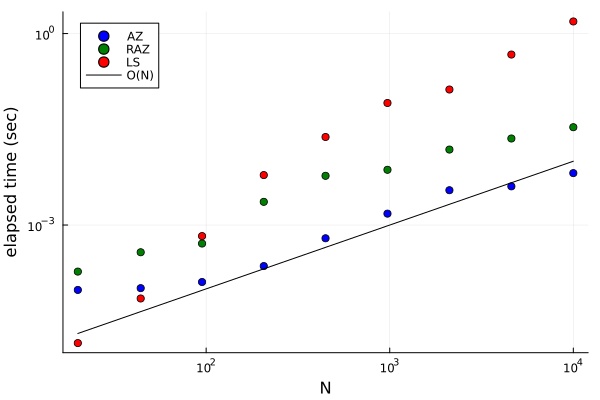

In [7]:
# this takes about eight minutes on my laptop
NN = ceil.(Int, 10 .^(LinRange(1.3, 4, 9)))
scatter(NN,[x[3] for x in fourierlegendre_az1.(NN, 5, fun; timing=true)], label=:"AZ", xaxis=:log, yaxis=:log, xlabel="N", ylabel="elapsed time (sec)",markercolor=:blue)
scatter!(NN,[x[3] for x in fourierlegendre_randaz.(NN, 5, fun; timing=true)], label=:"RAZ",markercolor=:green)
scatter!(NN,[x[3] for x in fourierlegendre_ls.(NN, 5, fun; timing=true)], label=:"LS",markercolor=:red)
plot!(NN, NN./10^6,label=:"O(N)",legend=:topleft, color=:black)

### Section 4.1.2 Approximation using an equispaced grid with extra points

In [8]:
# approximate fun using N Fourier functions and K Legendre polynomials on an equispaced grid (M_N = N) and points clustered towards the boundaries (M_K = 2K)
# using the AZ algorithm for enriched bases
function fourierlegendre_az2(N, K, fun; timing=false, errornorm="L2")
    approxset = Fourier(N) ⊕ (Legendre(K+1) → (0..1))[2:end]
    basis = component(approxset,1)
    enriched = component(approxset,2)

    samples1 = UnitPeriodicEquispacedGrid(N)
    samples2 = ScatteredGrid( [1 ./range(1,1e3,K); 1 .- 1 ./range(1,1e3,K)] )
    Z11 = BasisFunctions.leastsquares(basis, samples1)
    A21 = evaluation(basis, samples2)
    A12 = evaluation(enriched, samples1)
    A22 = evaluation(enriched, samples2)
    rhs = [fun.(samples1); fun.(samples2)]

    t = timing ? median(@benchmark(enrichedaz($A12, $A21, $A22, $Z11, $rhs))).time*1e-9 : 0.             # time in seconds

    if (~timing)
        coeff = enrichedaz(A12, A21, A22, Z11, [fun.(samples1); fun.(samples2)])
        approx = Expansion(approxset, BlockArray(coeff, [N,K]))
        xx = UnitPeriodicEquispacedGrid(2000)    # error grid
        m = (errornorm == "L2") ? norm(fun.(xx) - approx.(xx), 2)/sqrt(length(xx)) : (errornorm == "uniform") ? maximum(abs.(fun.(xx) - approx.(xx))) : error("unknown error norm")
    else
        m = 0.
        approx = Expansion(approxset, zeros(approxset))
    end

    m, approx, t
end

fourierlegendre_az2 (generic function with 1 method)

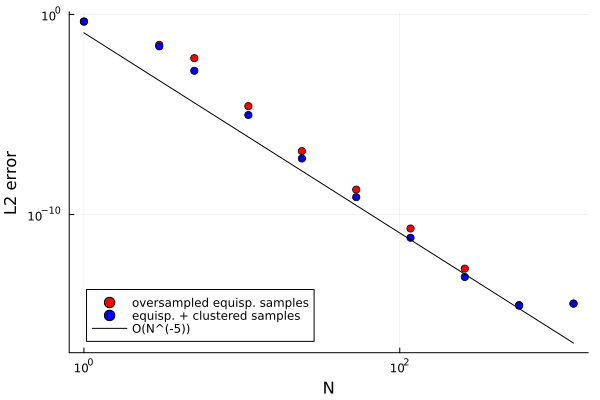

In [9]:
Nlist = ceil.(Int, 10 .^range(0,3.1,10))
scatter(Nlist,[x[1] for x in fourierlegendre_az1.(Nlist, 5, fun)], yaxis=:log, xaxis=:log, label="oversampled equisp. samples", ylabel="L2 error", xlabel="N",markercolor=:red)
scatter!(Nlist,[x[1] for x in fourierlegendre_az2.(Nlist, 5, fun)], label="equisp. + clustered samples",markercolor=:blue)
plot!(Nlist, .12*Nlist.^(-5),label=:"O(N^(-5))",legend=:bottomleft, color=:black)

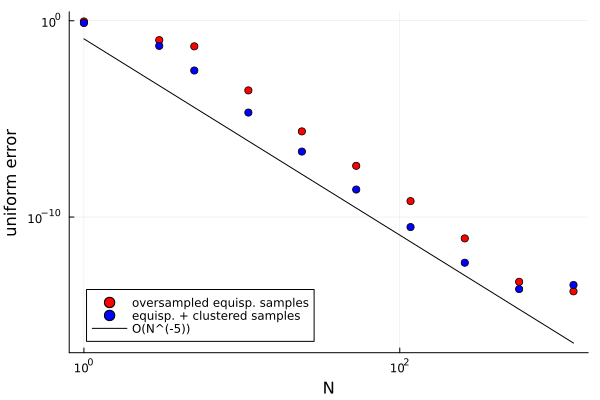

In [10]:
Nlist = ceil.(Int, 10 .^range(0,3.1,10))
scatter(Nlist,[x[1] for x in fourierlegendre_az1.(Nlist, 5, fun; errornorm="uniform")], yaxis=:log, xaxis=:log, label="oversampled equisp. samples", ylabel="uniform error", xlabel="N",markercolor=:red)
scatter!(Nlist,[x[1] for x in fourierlegendre_az2.(Nlist, 5, fun; errornorm="uniform")], label="equisp. + clustered samples",markercolor=:blue)
plot!(Nlist, .12*Nlist.^(-5),label=:"O(N^(-5))",legend=:bottomleft, color=:black)